In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget

In [33]:
scada_data = pd.read_csv("C:\\Users\\hanna\\Desktop\\data\\ScadaData.txt", delimiter='\t',  parse_dates=True)
scada_data['dtTimeStamp'] = pd.to_datetime(scada_data['dtTimeStamp'])
scada_data.index = scada_data['dtTimeStamp']

single_sensor_wind_speed = scada_data[scada_data["intObjectId"] == 1748][["WindDirectionMean","WindSpeedMean"]]
single_sensor_wind_speed.dropna(inplace=True)
print(single_sensor_wind_speed.head(5))

                     WindDirectionMean  WindSpeedMean
dtTimeStamp                                          
2019-08-01 00:00:00               89.4            3.0
2019-08-01 00:10:00               90.5            3.2
2019-08-01 00:20:00               90.6            4.7
2019-08-01 00:30:00               75.3            6.0
2019-08-01 00:40:00               73.2            6.2


## Rolling statistics
If the rolling statistics exhibit a clear trend (upwards or downwards) and show varying variance (increasing or decreasing amplitude), then you might conclude that the series is very likely not to be stationary.

In [34]:
rolling_window_size = 72

### Rolling Mean

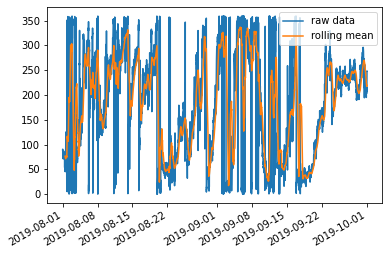

In [35]:
fig, ax = plt.subplots()
ax.plot(single_sensor_wind_speed.index, single_sensor_wind_speed["WindDirectionMean"], label='raw data')
ax.plot(single_sensor_wind_speed["WindDirectionMean"].rolling(window=rolling_window_size).mean(), label="rolling mean");
ax.legend()
fig.autofmt_xdate()

#### Standardized / Detrended Rolling Mean

In [36]:
single_sensor_wind_speed['z_data'] = (single_sensor_wind_speed['WindDirectionMean'] - single_sensor_wind_speed['WindDirectionMean'].rolling(window=rolling_window_size).mean()) / single_sensor_wind_speed['WindDirectionMean'].rolling(window=rolling_window_size).std()


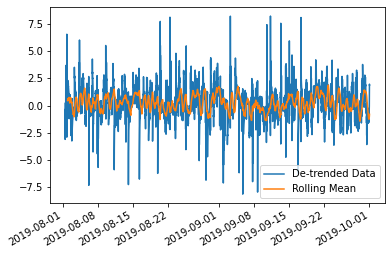

In [37]:
fig, ax = plt.subplots()
ax.plot(single_sensor_wind_speed.index, single_sensor_wind_speed['z_data'], label="De-trended Data")
ax.plot(single_sensor_wind_speed['z_data'].rolling(window=rolling_window_size).mean(), label="Rolling Mean");
ax.legend()
fig.autofmt_xdate()

#### Differenced De-Trended Rolling Mean

In [38]:
single_sensor_wind_speed['zp_data'] = single_sensor_wind_speed['z_data'] - single_sensor_wind_speed['z_data'].shift(1)

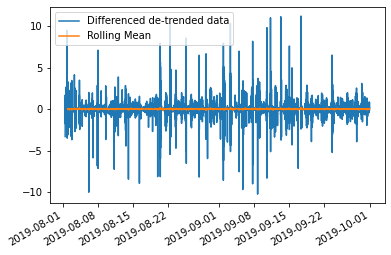

In [39]:
fig, ax = plt.subplots()
ax.plot(single_sensor_wind_speed.index, single_sensor_wind_speed['zp_data'], label="Differenced de-trended data")
ax.plot(single_sensor_wind_speed['zp_data'].rolling(window=rolling_window_size).mean(), label="Rolling Mean");
ax.legend()
fig.autofmt_xdate()

### Rolling Standard Deviation

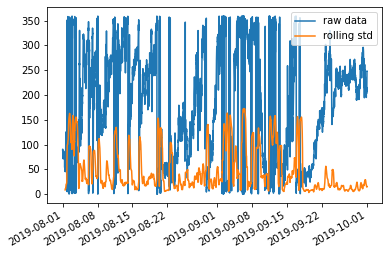

In [40]:
fig, ax = plt.subplots()
ax.plot(single_sensor_wind_speed.index, single_sensor_wind_speed["WindDirectionMean"], label='raw data')
ax.plot(single_sensor_wind_speed["WindDirectionMean"].rolling(window=rolling_window_size).std(), label="rolling std");
ax.legend()
fig.autofmt_xdate()

#### De-Trended Rolling Standard Deviation

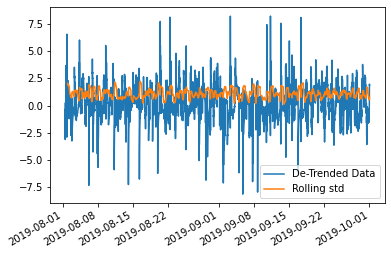

In [41]:
fig, ax = plt.subplots()
ax.plot(single_sensor_wind_speed.index, single_sensor_wind_speed["z_data"], label="De-Trended Data")
ax.plot(single_sensor_wind_speed["z_data"].rolling(window=rolling_window_size).std(), label="Rolling std");
ax.legend()
fig.autofmt_xdate()

#### Differenced De-Trended Stand Deviation

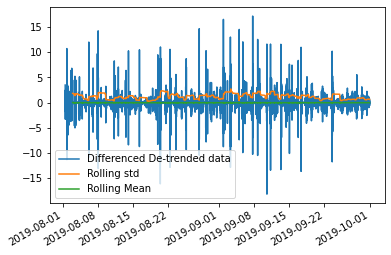

In [42]:
single_sensor_wind_speed["zp2_data"] = single_sensor_wind_speed["zp_data"] - single_sensor_wind_speed["zp_data"].shift(1)
fig, ax = plt.subplots()
ax.plot(single_sensor_wind_speed.index, single_sensor_wind_speed["zp2_data"], label="Differenced De-trended data")
ax.plot(single_sensor_wind_speed["zp2_data"].rolling(window=rolling_window_size*3).std(), label="Rolling std");
ax.plot(single_sensor_wind_speed['zp2_data'].rolling(window=rolling_window_size*3).mean(), label="Rolling Mean");
ax.legend()
fig.autofmt_xdate()

### Augmented Dickey-Fuller Test

In [43]:
from statsmodels.tsa.stattools import adfuller



print(" > Is the data stationary ?")
dftest = adfuller(single_sensor_wind_speed["WindDirectionMean"], autolag='AIC')
print("Test statistic = {:.20f}".format(dftest[0]))
print("P-value = {:.20f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(single_sensor_wind_speed.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.20f}".format(dftest[0]))
print("P-value = {:.20f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print(f"\n > Is the 1-lag differenced de-trended data stationary ?")
dftest = adfuller(single_sensor_wind_speed.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.20f}".format(dftest[0]))
print("P-value = {:.20f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -6.93311253254040771310
P-value = 0.00000000107145916493
Critical values :
	1%: -3.4310987663135504 - The data is  stationary with 99% confidence
	5%: -2.8618709048976445 - The data is  stationary with 95% confidence
	10%: -2.5669461357077656 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -14.39853670638144400584
P-value = 0.00000000000000000000
Critical values :
	1%: -3.431102991063111 - The data is  stationary with 99% confidence
	5%: -2.861872771719298 - The data is  stationary with 95% confidence
	10%: -2.5669471294298076 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -23.88100612642329778623
P-value = 0.00000000000000000000
Critical values :
	1%: -3.4311044679536593 - The data is  stationary with 99% confidence
	5%: -2.861873424323334 - The data is  stationary with 95% confidence
	10%: -2.5669474768155447 - T

###### KPSS

In [44]:
from statsmodels.tsa.stattools import kpss

for column in ["WindDirectionMean", 'z_data', "zp_data"]:
    print(column)
    statistic, p_value, n_lags, critical_values = kpss(single_sensor_wind_speed[column].dropna())
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary\n')


WindDirectionMean
KPSS Statistic: 0.5765767826472245
p-value: 0.0247657470320705
num lags: 37
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary

z_data
KPSS Statistic: 0.11277151034327595
p-value: 0.1
num lags: 37
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary

zp_data
KPSS Statistic: 0.003300061755040292
p-value: 0.1
num lags: 37
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary



C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values 

#### Autocorrelation plots (ACF & PACF)

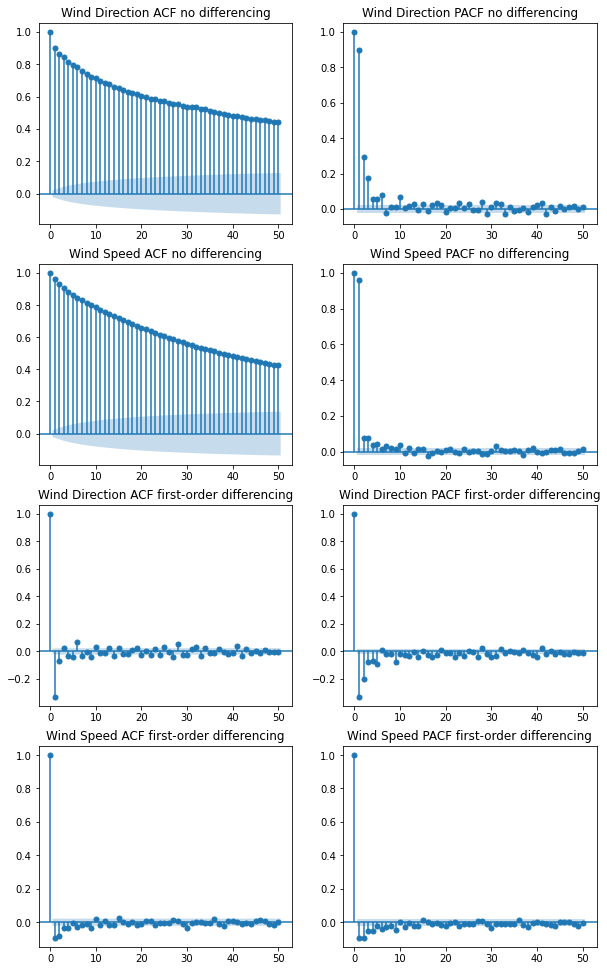

In [75]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

single_sensor_wind_speed['diff_data_d'] = single_sensor_wind_speed['WindDirectionMean'] - single_sensor_wind_speed['WindDirectionMean'].shift(-1)
single_sensor_wind_speed['diff_data_s'] = single_sensor_wind_speed['WindSpeedMean'] - single_sensor_wind_speed['WindSpeedMean'].shift(-1)


fig, ax = plt.subplots(4,2,figsize=(10,17))
sm.graphics.tsa.plot_acf(single_sensor_wind_speed['WindDirectionMean'], ax=ax[0,0], lags=50, title="Wind Direction ACF no differencing")

sm.graphics.tsa.plot_pacf(single_sensor_wind_speed['WindDirectionMean'], ax=ax[0,1], lags=50, title="Wind Direction PACF no differencing")

sm.graphics.tsa.plot_acf(single_sensor_wind_speed['WindSpeedMean'], ax=ax[1,0], lags=50, title="Wind Speed ACF no differencing")

sm.graphics.tsa.plot_pacf(single_sensor_wind_speed['WindSpeedMean'], ax=ax[1,1], lags=50, title="Wind Speed PACF no differencing")

sm.graphics.tsa.plot_acf(single_sensor_wind_speed['diff_data_d'].dropna(), ax=ax[2,0], lags=50, title="Wind Direction ACF first-order differencing")

sm.graphics.tsa.plot_pacf(single_sensor_wind_speed['diff_data_d'].dropna(), ax=ax[2,1], lags=50, title="Wind Direction PACF first-order differencing")

sm.graphics.tsa.plot_acf(single_sensor_wind_speed['diff_data_s'].dropna(), ax=ax[3,0], lags=50, title="Wind Speed ACF first-order differencing")

sm.graphics.tsa.plot_pacf(single_sensor_wind_speed['diff_data_s'].dropna(), ax=ax[3,1], lags=50, title="Wind Speed PACF first-order differencing")


plt.savefig('acf_pacf.jpg')